# Kaggle Tabular dataset competitions

In [23]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from sklearn.metrics import log_loss
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
import xgboost as xgb
from sklearn.metrics import accuracy_score
import mlflow
import mlflow.xgboost
import mlflow.sklearn

In [24]:
!which pip3


/Users/m98612/venv/fradrag2021/bin/pip3


# Load the data to a dataframe

In [25]:
"""
Load in all data used for train and test
"""
# read in data from train and test csv files
train_labels = pd.read_csv('train_labels.csv')
#print out the first 5 rows of the train_labels dataframe


#read all files in folder submission files as dataframes, and concatenate them into one dataframe using tqdm for progress bar
submission_files = os.listdir('submission_files')
submission_files = [file for file in submission_files if file.endswith('.csv')]
submission_dfs = []
for file in tqdm.tqdm(submission_files):
    submission_dfs.append(pd.read_csv('submission_files/'+file)["pred"])

submission_df2 = pd.concat(submission_dfs, axis=1)


#make colnames filename:
columns = [i for i in submission_files]
#remove .csv from columns names:
columns = [i[:-4] for i in columns]
submission_df2.columns = columns



100%|██████████| 5000/5000 [01:04<00:00, 77.73it/s]


In [26]:
submission_df2

,0.7131772137,0.6935182933,0.7260013220,0.7152632882,0.7005385368,0.6854126675,0.7439608123,0.6945358038,0.7261839834,0.6599155304,...,0.6902588526,0.7092127612,0.6706922694,0.6855709925,0.7114491506,0.6817741142,0.7030287611,0.7331661007,0.6841581492,0.7167146788
0,0.778224,0.762953,0.764103,0.723772,0.803894,0.784736,0.836666,0.775778,0.774012,0.919990,...,0.766138,0.779247,0.327731,0.759982,0.789323,0.782428,0.790650,0.757342,0.781069,0.847858
1,0.569151,0.572876,0.562022,0.762576,0.597722,0.646278,0.555181,0.577722,0.652896,0.579136,...,0.602346,0.499591,0.309518,0.521851,0.623097,0.574567,0.713203,0.603681,0.748823,0.544203
2,0.851960,0.721607,0.894352,0.823561,0.813720,0.798389,0.901490,0.795233,0.823106,0.841735,...,0.770273,0.775682,0.370162,0.844858,0.819129,0.743486,0.800796,0.827598,0.770387,0.834842
3,0.774035,0.713205,0.569785,0.827587,0.752170,0.763516,0.697942,0.757559,0.830138,0.780352,...,0.721262,0.718068,0.708552,0.674332,0.724067,0.675280,0.785302,0.830872,0.710615,0.774971
4,0.947631,0.961040,0.915259,0.890565,0.943416,0.955314,0.950565,0.961459,0.945953,0.952285,...,0.960027,0.984533,0.879385,0.906421,0.941764,0.862694,0.944611,0.947302,0.934213,0.952894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.524607,0.475706,0.668804,0.660779,0.597722,0.520916,0.474161,0.492554,0.479358,0.492087,...,0.548409,0.578763,0.308542,0.428860,0.540553,0.424866,0.518174,0.646381,0.523170,0.527779
39996,0.466011,0.681494,0.597660,0.604560,0.597722,0.614027,0.588607,0.581670,0.692622,0.504424,...,0.617470,0.541461,0.669970,0.584085,0.512339,0.545916,0.564931,0.557322,0.567804,0.451140
39997,0.814648,0.749162,0.767753,0.685436,0.752170,0.742078,0.788279,0.719764,0.718449,0.781666,...,0.742763,0.712222,0.336279,0.640871,0.779318,0.821522,0.759289,0.612618,0.755785,0.682672
39998,0.827715,0.745039,0.718799,0.633344,0.803894,0.716987,0.819962,0.741298,0.846074,0.778603,...,0.736480,0.751111,0.690340,0.739461,0.860258,0.783374,0.812915,0.776783,0.747203,0.837260


# Start looking at different data cleaning techniques:

In [29]:
# differentiate the dataset into the one we have lables for and the one we do not have lables for
traintest_df = submission_df2.iloc[:int(len(submission_df2)/2)]
validation_df = submission_df2.iloc[int(len(submission_df2)/2):]
# add targets to the train_df from train_labels:
traintest_df = pd.concat([traintest_df, train_labels["label"]], axis=1)



# Do the model training:

In [30]:
# define the input model data and amek a train test split

X, y  = traintest_df.drop("label", axis=1), traintest_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [31]:

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    #set small alpha:
    'alpha': 0.1,
    'lambda': 1,
    'seed': 42
}

print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")
dtrain = xgb.DMatrix(X_train, label=y_train )
dtest = xgb.DMatrix(X_test, label=y_test)
print(y_train.shape)
print(y_test.shape)


(16000, 5000) X_train shape
(4000, 5000) X_test shape
(16000,)
(4000,)


In [32]:
# print output for each 50th iteration:
watchlist = [(dtrain, 'train'), (dtest, 'test')]
with mlflow.start_run():
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=watchlist,evals_result = evals_result, verbose_eval=5, early_stopping_rounds=50)
    y_pred = model.predict(dtest)

[0]	train-logloss:0.66313	test-logloss:0.66605
[5]	train-logloss:0.56827	test-logloss:0.58592
[10]	train-logloss:0.52053	test-logloss:0.55128
[15]	train-logloss:0.49150	test-logloss:0.53603
[20]	train-logloss:0.47152	test-logloss:0.52871
[25]	train-logloss:0.45708	test-logloss:0.52519
[30]	train-logloss:0.44613	test-logloss:0.52405
[35]	train-logloss:0.43485	test-logloss:0.52330
[40]	train-logloss:0.42673	test-logloss:0.52395
[45]	train-logloss:0.41920	test-logloss:0.52413
[50]	train-logloss:0.41000	test-logloss:0.52491
[55]	train-logloss:0.40305	test-logloss:0.52552
[60]	train-logloss:0.39121	test-logloss:0.52646
[65]	train-logloss:0.38300	test-logloss:0.52753
[70]	train-logloss:0.37366	test-logloss:0.52788
[75]	train-logloss:0.36421	test-logloss:0.52818
[80]	train-logloss:0.35633	test-logloss:0.52889
[84]	train-logloss:0.34960	test-logloss:0.52951


In [33]:
# calculate accuracy using round:
y_pred_round = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_round)


logloss = log_loss(y_test, y_pred)

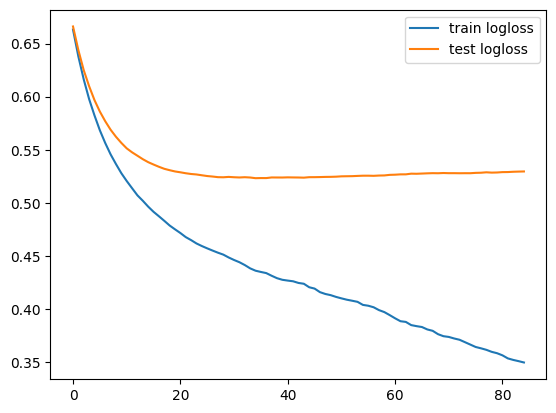

In [34]:

# plot logloss over time for train and test sets:
plt.plot(evals_result['train']['logloss'], label='train logloss')
plt.plot(evals_result['test']['logloss'], label='test logloss')


plt.legend()
plt.show()



In [35]:

best_iteration = model.best_iteration
print(best_iteration)





34


In [36]:
#Prep the submission format:
validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
validation_df["id"] = validation_df.index

#save to file:
validation_df[["id", "pred"]].to_csv("results/submission.csv", index=False)

/Users/m98612/venv/fradrag2021/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

# Test of Hyperopt

In [114]:

search_space = {
    "objective": "binary:logistic",  # objective
    "eta": hp.loguniform("learning_rate", -4, -1.2),  # learning rate
    "min_child_weight": hp.loguniform(
        "min_child_weight", -1, 3
    ),  # minimum sum of weights of all observations required in child.
    "max_depth": scope.int(hp.quniform("max_depth", 4, 50, 1)),
    "subsample": hp.loguniform(
        "subsample", -0.91, 0
    ),  # fraction of observations to be randomly samples for each tree.
    "colsample_bytree": hp.loguniform(
        "colsample_bytree", -0.91, 0
    ),  # fraction of columns to be randomly sampled for each tree.
    "colsample_bylevel": hp.loguniform(
        "colsample_bylevel", -0.91, 0
    ),  # subsample ratio of columns for each split, in each level.
    "lambda": hp.loguniform(
        "lambda", -4, 0
    ),  # L2 regularization term on weights (Ridge)
    "alpha": hp.loguniform(
        "alpha", -4, -1.2
    ),  # L1 regularization term on weight (Lasso)
    "gamma": hp.loguniform(
        "gamma", -6, 2.7
    ),  # minimum loss reduction required to make a split
    "seed": 41,
}


def objective(search_space):
    """
    Encapsulated objective-function such that hyperopt function can reach input-data in objective function
    """
    dtrain = xgb.DMatrix(X_train.copy(), label=y_train)
    dtest = xgb.DMatrix(X_test.copy(), label=y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    verbose_eval = 50
    with mlflow.start_run(nested=True):
        search_space["eval_metric"] = ["error", "auc", "logloss"]
        num_round = 3000
        evals_result = {}
        num_features = 80
        bst = xgb.train(
            search_space,
            dtrain,
            num_round,
            evals=watchlist,
            evals_result=evals_result,
            early_stopping_rounds=100,
            verbose_eval=verbose_eval,
        )
        print(f"Stopping after {len(evals_result['train']['error'])} rounds")


        min_logloss_error= np.min(evals_result["eval"]["logloss"])
        mlflow.xgboost.log_model(bst, artifact_path="model")

        return {
            "status": STATUS_OK,
            "loss": min_logloss_error,
            "booster": bst.attributes(),
        }



ModuleNotFoundError: No module named 'hyperopt'

In [ ]:
#
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


with mlflow.start_run(run_name=f"xgb_{ds_short}"):
    best_params = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
    )
